In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import cv2
from cycler import cycler
import matplotlib.colors as mcolors

plt.style.use(['science', 'grid'])
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['font.size'] = 8
plt.rcParams['lines.markersize'] = 2.5
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams['grid.alpha'] = .2

T = lambda I: 108.0958765*I*I*I-511.9765339*I*I+1617.95649045*I+537.60415503

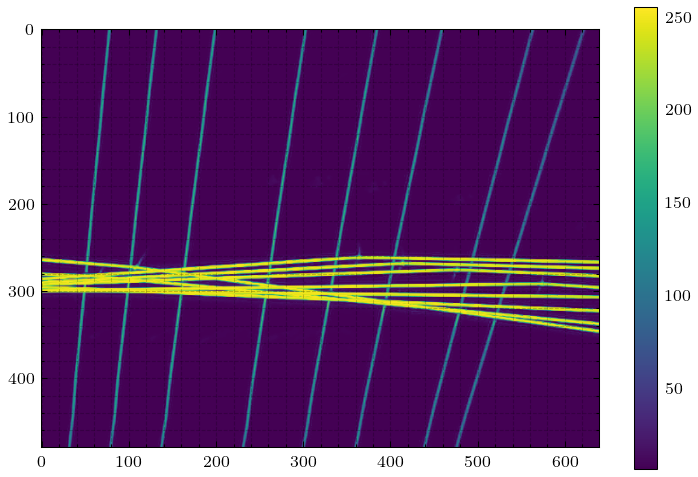

In [35]:
images = np.array([cv2.imread(f"out/{i}_1400_original.png", cv2.IMREAD_GRAYSCALE) for i in range(1, 9)])
image_max = np.maximum.reduce(images)

plt.imshow(image_max)
plt.colorbar()
plt.show()

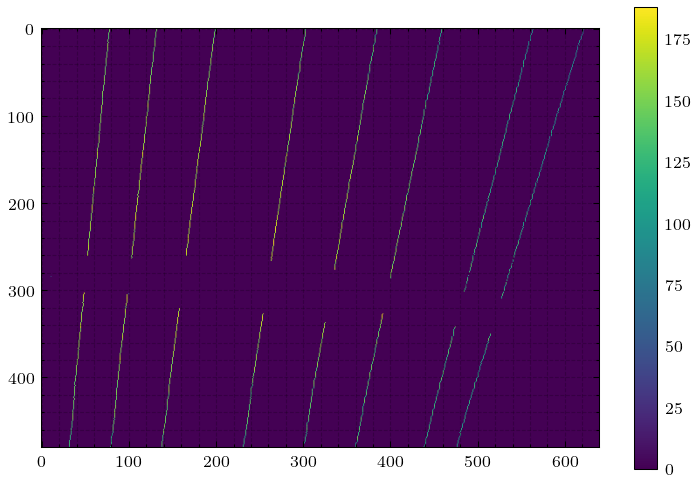

In [36]:
upper_lim = 190
lower_lim = 40
window_shift = 20
wire_shift = 0

for image in images:
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i, j] > upper_lim:
                image[i-window_shift:i+window_shift, j-window_shift:j+window_shift] = 0
        max_j = image[i].argmax()
        image[i, :max_j-wire_shift] = 0
        image[i, max_j+wire_shift+1:] = 0

image_max = np.maximum.reduce(images)
image_filter = np.where((image_max > lower_lim) & (image_max < upper_lim), image_max, np.zeros_like(image_max))

plt.imshow(image_filter)
plt.colorbar()
plt.show()

In [37]:
def surface2d(coefficients, x_grid, y_grid):
    return coefficients[0] + \
    coefficients[1] * x_grid + \
    coefficients[2] * y_grid + \
    coefficients[3] * x_grid**2 + \
    coefficients[4] * x_grid * y_grid + \
    coefficients[5] * y_grid**2

def fit_2d_polynomial_and_calibrate(image):
    """
    Аппроксимирует двумерный полином второго порядка по ненулевым пикселям
    """
    # 1. Находим координаты ненулевых пикселей
    nonzero_indices = np.nonzero(image)
    y_coords, x_coords = nonzero_indices
    z_values = image[y_coords, x_coords]
    
    # 2. Создаем матрицу признаков для полинома второго порядка
    # Для формулы: a₀ + a₁x + a₂y + a₃x² + a₄xy + a₅y²
    X = np.column_stack([
        np.ones_like(x_coords),  # a₀
        x_coords,                # a₁
        y_coords,                # a₂
        x_coords**2,             # a₃
        x_coords * y_coords,     # a₄
        y_coords**2              # a₅
    ])
    
    # 3. Решаем систему линейных уравнений методом наименьших квадратов
    coefficients, _, _, _ = np.linalg.lstsq(X, z_values)
    
    # 4. Создаем сетку координат для всего изображения
    height, width = image.shape
    y_grid, x_grid = np.mgrid[0:height, 0:width]
    
    # 5. Вычисляем значения полинома для каждого пикселя изображения
    poly_surface = surface2d(coefficients, x_grid, y_grid)
    
    return (x_coords, y_coords, z_values), coefficients, poly_surface


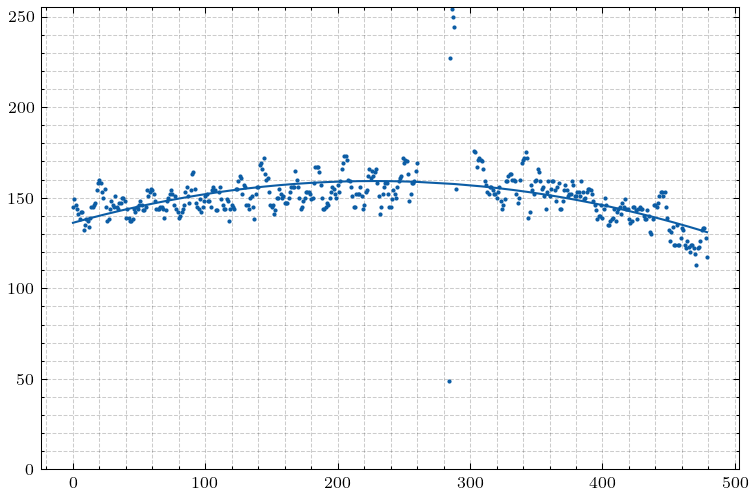

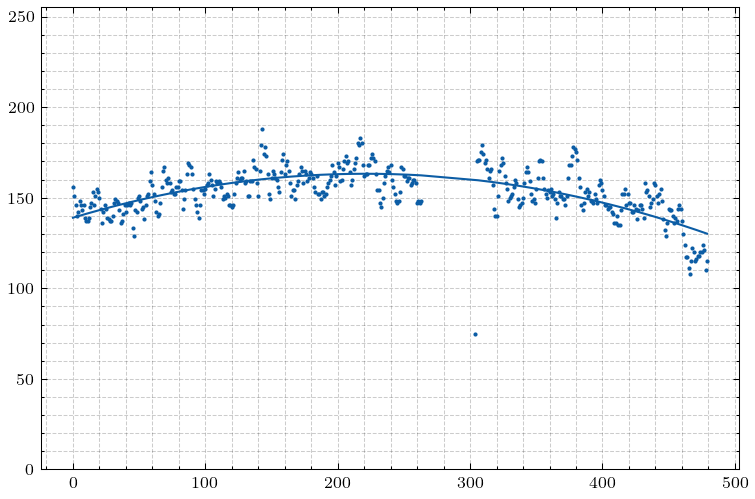

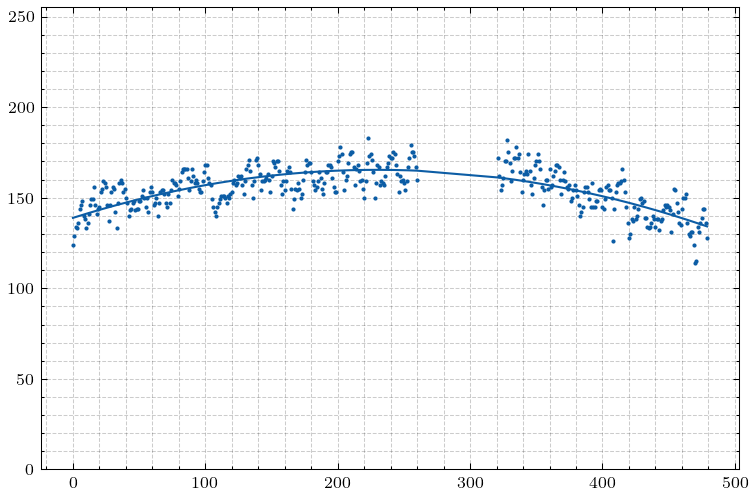

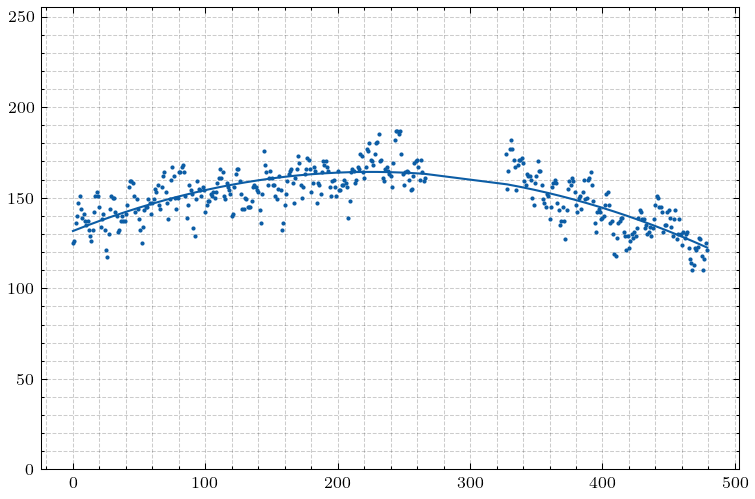

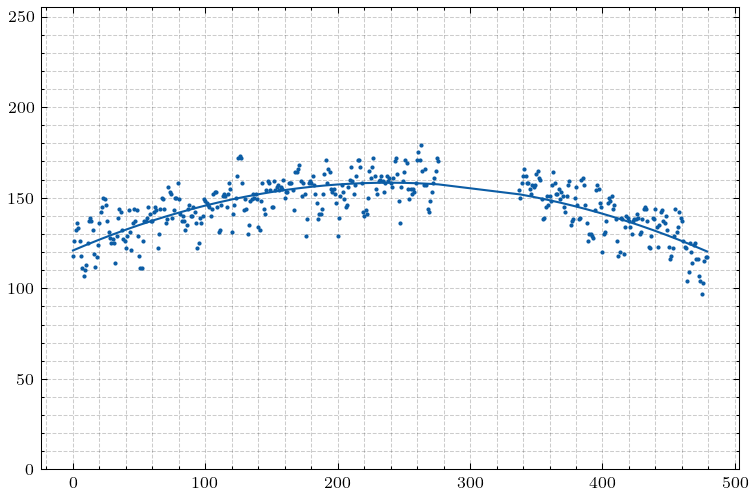

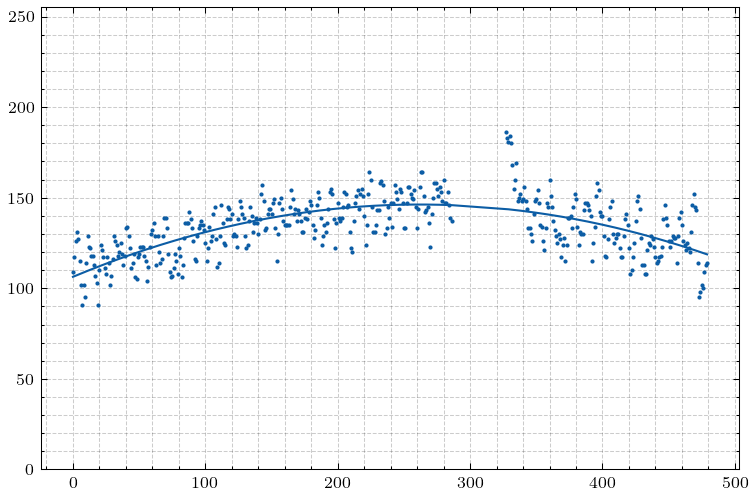

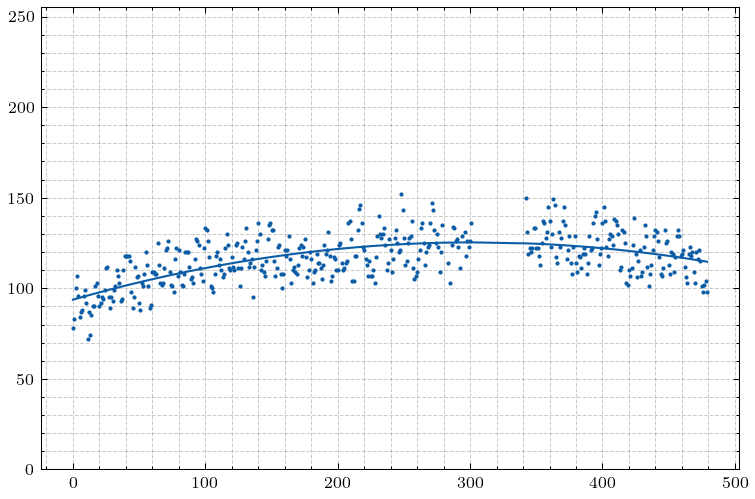

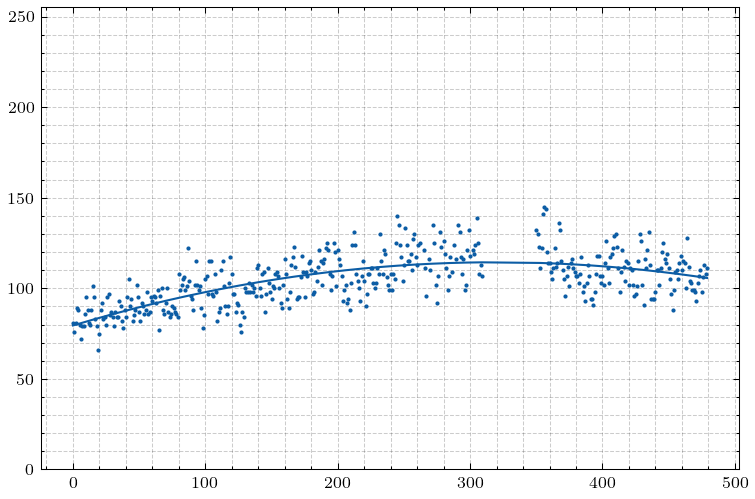

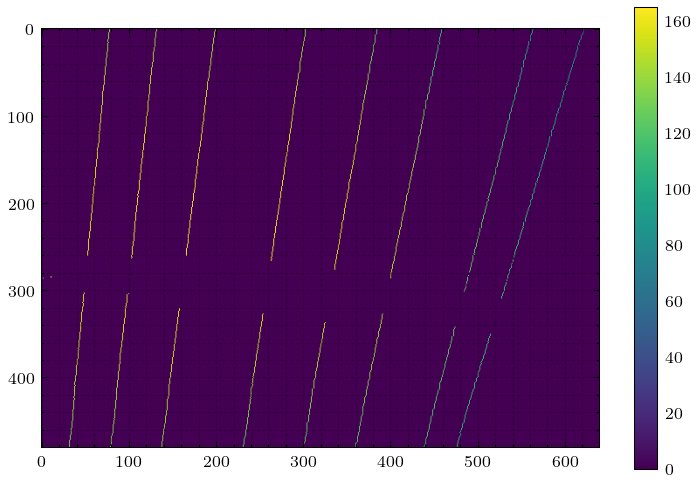

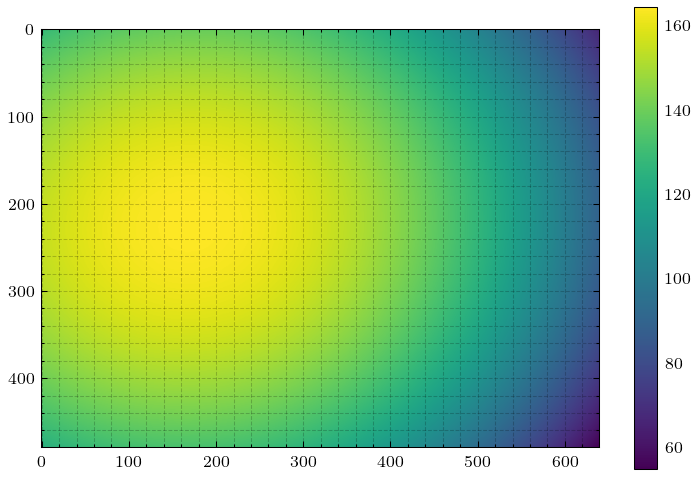

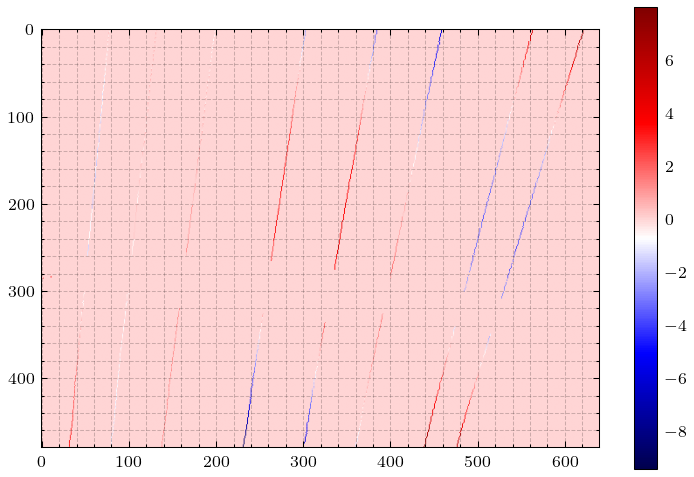

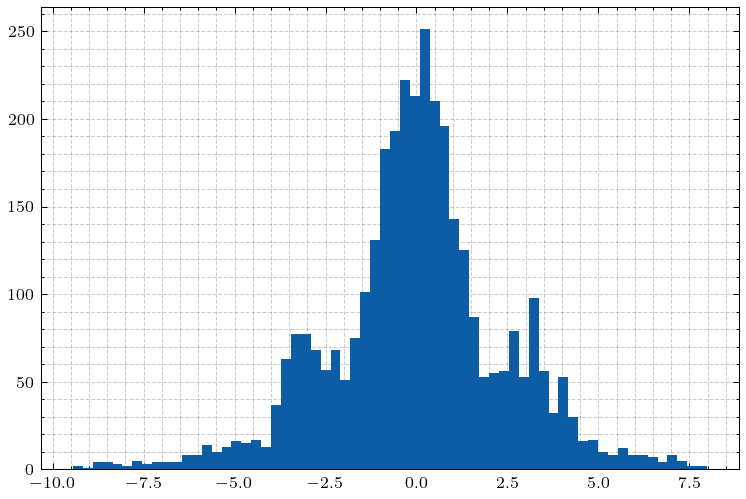

In [38]:
image_poly = np.zeros_like(images[0])
deg = 2

for image in images:
    plt.ylim(0, 255)
    
    i_arr = np.arange(image.shape[0])
    j_max = np.argmax(image, axis=1)
    Y_arr = image[i_arr, j_max]
    idx = (Y_arr > 40)

    i = i_arr[idx]
    j = j_max[idx]
    Y = Y_arr[idx]
    popt, pcov = np.polyfit(i, Y, deg, cov=True)
    p = np.poly1d(popt)

    plt.scatter(i, Y, s=1)
    plt.plot(i, p(i))
    plt.show()

    image_poly[i, j] = p(i)

plt.imshow(image_poly)
plt.colorbar()
plt.show()

(x_coords, y_coords, z_values), coeffs, poly_surface = fit_2d_polynomial_and_calibrate(image_poly)

zero = (image_poly == 0)
nonzero = (image_poly > 0)

poly_surface_by_parabola = poly_surface.copy()
plt.imshow(poly_surface)
plt.colorbar()
plt.show()

discrepancy = image_poly.astype(np.float64)
discrepancy[nonzero] -= poly_surface[nonzero]

plt.imshow(discrepancy, cmap='seismic')
plt.colorbar()
plt.show()

hist_values = discrepancy[discrepancy != 0].flatten()
plt.hist(hist_values, bins=64)
plt.show()

In [39]:
coeffs

array([ 1.28213386e+02,  1.20948505e-01,  2.27291192e-01, -3.41454905e-04,
       -2.33171747e-05, -4.92636352e-04])

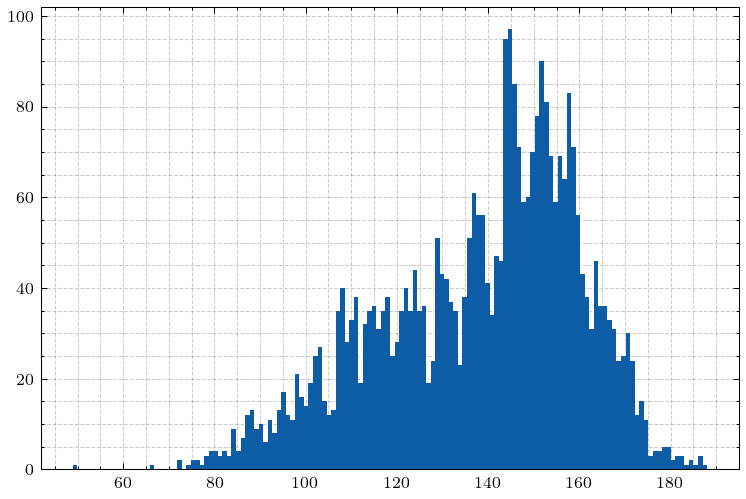

In [40]:
hist_values = image_filter[image_filter > 0].flatten()
plt.hist(hist_values, bins=hist_values.max()-hist_values.min()+1)
plt.show()

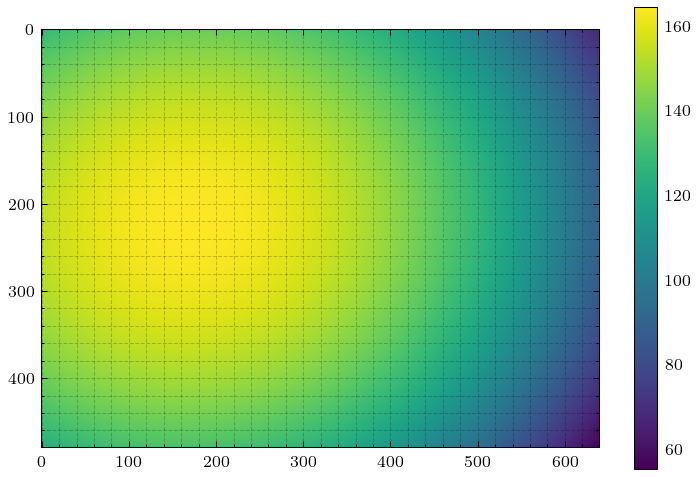

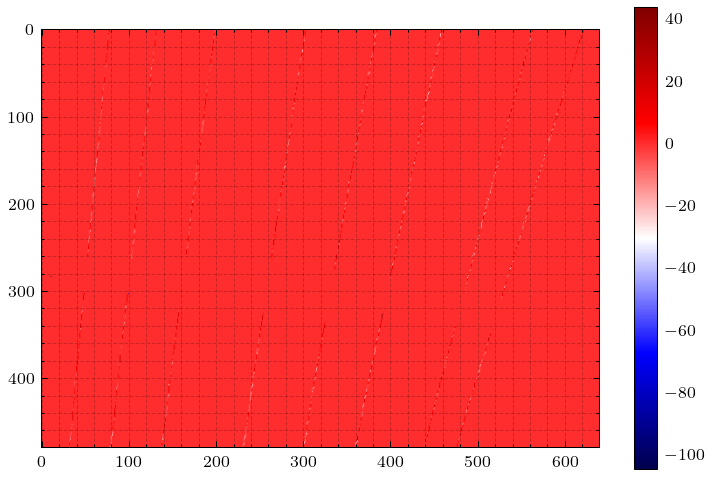

In [41]:
(x_coords, y_coords, z_values), coeffs, poly_surface = fit_2d_polynomial_and_calibrate(image_filter)

zero = (image_filter == 0)
nonzero = (image_filter > 0)

poly_surface_by_points = poly_surface.copy()
plt.imshow(poly_surface)
plt.colorbar()
plt.show()

discrepancy = image_filter.astype(np.float64)
discrepancy[nonzero] -= poly_surface[nonzero]

plt.imshow(discrepancy, cmap='seismic')
plt.colorbar()
plt.show()

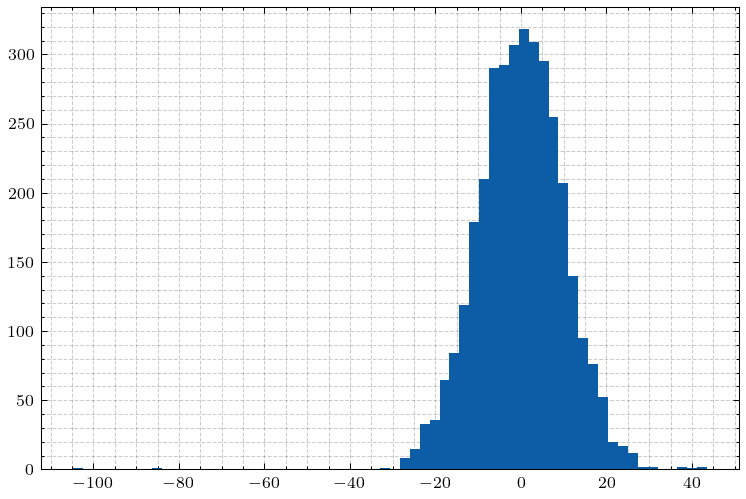

In [42]:
hist_values = discrepancy[discrepancy != 0].flatten()
plt.hist(hist_values, bins=64)
plt.show()

In [43]:
coeffs

array([ 1.28243475e+02,  1.26041457e-01,  2.23192454e-01, -3.48345371e-04,
       -2.31070672e-05, -4.84756086e-04])

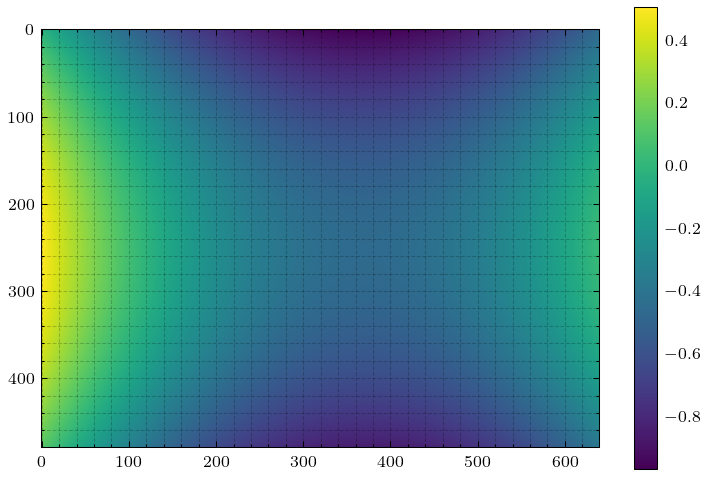

In [44]:
plt.imshow(poly_surface_by_parabola - poly_surface_by_points)
plt.colorbar()
plt.show()